## AMPTH 207: Stochastic Methods for Data Analysis, Inference and Optimization

### ANNs in PyMC3

**Harvard University**  
**Spring 2018**  
**Instructor: Rahul Dave**  

## Variational Inference for Hierarchical Feed Forward Neural Networks
Earlier in the course we've built models to predict a label from a discrete finite set for a given input - that is, we've built classifiers. When building these classifiers, we learn a function that maps certain input data to a set of outputs, usually the classes into which the dataset naturally separate. In the case of a Artificial Neural Network (ANN) like the Multi-Layer Perceptron, the learning is achieved by iteratively updating the weights that regulate the flow of information between the different layers of the ANN. We have also seen that it is possible to regularize our model we learn by penalizing the magnitude of some of the weights - this is done in order to avoid overfitting. This type of regularization can be accomplished by  imposing priors on the weights when they are initialized.

This approach is inherently Bayesian. We can specify priors to inform and constrain our models and get uncertainty estimations in the form of a posterior distribution. Using MCMC sampling algorithms we can draw samples from this posterior to very flexibly estimate these models. This also means that we can obtain uncertainties on both the weights and the classes that we obtain from the output layer.

In this problem you are asked to build a hierarchical Bayesian ANN to classify the MNIST dataset (properly split into training and test sets) and to infer uncertainties for the weighths and the resulting classes. Variational inference can become very handy here: instead of drawing samples from the posterior, these algorithms fit a distribution (e.g. normal) to the posterior turning a sampling problem into and optimization problem. ADVI -- Automatic Differentation Variational Inference is implemented in PyMC3 and Stan.

### Bayesian ANN

In HW3 you built a multi-layer perceptron to classify the MNIST dataset.

Here we will build a Bayesian Artificial Neural Network. 

Build an artificial neural network in pymc3 (or Stan, your choice) with two hidden layers and 25 neurons in each, and use it to classify the MNIST dataset. The architecture will look like the one below:
<img src="ANN2.png">
Recall that for each node in a fixed layer, you will be applying an activation function to a linear combination of the outputs from the previous layer with a constant term (called the bias):
<img src="ANN.jpg">

Use the $\tanh$ function as the activation function, and initialize ALL the weights using using normal priors with $\mu=0$ and two different values for $\sigma = 0.03, 0.1$.

1. You could use a MCMC sampler such as NUTS to train your model. But this will be extremely slow as you add more layer or more units. Instead, use the PyMC3/Stan ADVI implementation to approximate the posteriors of the weights, and obtain the posterior means, standard deviations, and the evidence lower bound (ELBO), which is your objective function. Use mini-batch gradient descent for the optimization (a minibatch size of 500 is appropriate), and a todal of 50000 ADVI iterations.

  **Hint:** You should organize the weights between two consecutive layers as a matrix. It would be extremely beneficial for you to first work out the dimensions of these matrices before doing any coding.
  
  $\square$
  
2. Plot the objective function (ELBO) as a function of the iteration. Using the best fit from your training, predict on the test set by estimating posterior predictives for the classes in each case, and provide the accuracy of your classification. How does your accuracy compare for the two values of $\sigma$? 

**Hint:** if you need traces to perform inference, you can sample directly from the normal distribution that ADVI outputs.

### Solution:



First and as usual, we load the required libraries.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('white')
sns.set_context('talk')

import pymc3 as pm
import theano.tensor as T
import theano

floatX = theano.config.floatX


from scipy.stats import mode, chisquare
from sklearn.metrics import confusion_matrix, accuracy_score

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
/home/igodo/.virtualenvs/AM207-SakPYaa-/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Next, we load in the MNIST dataset from Long Homework 1. 

In [2]:
import gzip
import pickle

# To read the dataset
dataset='mnist.pkl.gz'
with gzip.open(dataset, 'rb') as f:
        try:
            train_set, valid_set, test_set = pickle.load(f, encoding='latin1')
        except:
            train_set, valid_set, test_set = pickle.load(f)

We combine the preloaded validation and test sets into a single test set. 

In [3]:
# Obtain training and test data
train_x = np.array(train_set[0])
train_y = np.array(train_set[1])

test_x = np.concatenate((np.array(test_set[0]), np.array(valid_set[0])))
test_y = np.concatenate((np.array(test_set[1]), np.array(valid_set[1])))

print("Dimensions of training data", train_x.shape)
print("Dimensions of test data", test_x.shape)

Dimensions of training data (50000, 784)
Dimensions of test data (20000, 784)


In [4]:
data_train_x = pm.Minibatch(train_x, batch_size=500)
data_train_y = pm.Minibatch(train_y, batch_size=500)

We have 50000 handwritten digits for training, and 20000 for testing. The pixel values are already standardized so we don't need to do any further preprocessing.

We now implement our Bayesian ANN with the specified architecture using pymc3. By matrix multiplication, we find that the weight matrices should have the following dimensions:

- Weights from input to first hidden layer - $784 \times 25$
- Weights from first to second hidden layers - $25 \times 25$
- Weights from second hidden layer to output layer - $25 \times 10$

We first handle the case when $\sigma = 0.03$.

In [5]:
# Code below adapted from http://twiecki.github.io/blog/2016/07/05/bayesian-deep-learning/
total_size = len(train_y)

In [6]:

ann_input = theano.shared(train_x)
ann_output = theano.shared(train_y)

n_hidden = 25 # Number of neurons in each hidden unit

# initialize
init_1 = np.random.randn(train_x.shape[1], n_hidden).astype(floatX)
init_2 = np.random.randn(n_hidden, n_hidden).astype(floatX)
init_out = np.random.randn(len(np.unique(train_y))).astype(floatX)
    
with pm.Model() as neural_network:
    
    # Weights from input to hidden layer
    weights_in_1 = pm.Normal('w_in_1', 0, sd = 0.03, 
                             shape=(train_x.shape[1], n_hidden), testval=init_1)
    
    # Weights from 1st to 2nd layer
    weights_1_2 = pm.Normal('w_1_2', 0, sd = 0.03, 
                            shape=(n_hidden, n_hidden), testval=init_2)

    # Weights from hidden layer to output
    weights_2_out = pm.Normal('w_2_out', 0, sd= 0.03, 
                              shape=(n_hidden, len(np.unique(train_y))), testval=init_out)
    
    # Bias terms for hidden layer 1
    bias_1 = pm.Normal('b1', 0, sd = 0.03)
    
    # Bias terms for hidden layer 2
    bias_2 = pm.Normal('b2', 0, sd = 0.03)
    
    # Bias term for output layer
    bias_3 = pm.Normal('b3', 0, sd = 0.03)
    
    # Build neural-network using tanh activation function
    act_1 = T.tanh(T.dot(ann_input, 
                         weights_in_1) + bias_1)
    act_2 = T.tanh(T.dot(act_1, 
                         weights_1_2) + bias_2)
    
    act_out = T.nnet.softmax(T.dot(act_2, weights_2_out) + bias_3)
    
    out = pm.Categorical('out', 
                         act_out,
                         observed=ann_output, total_size=total_size)

The code below coerces our data into mini-batches of size 500, which will speed up training. (Taken from http://twiecki.github.io/blog/2016/06/01/bayesian-deep-learning/).

Now, we use mini-batch gradient descent for the optimization (50000 ADVI iterations).

In [ ]:
advi_params = {
    ann_input: pm.Minibatch(train_x, batch_size=500, dtype='float32'), 
    ann_output: pm.Minibatch(train_y, batch_size=500)
}

with neural_network:
    inference=pm.ADVI()
    approx = pm.fit(n=50000, 
                    method=inference,
                    more_replacements=advi_params, 
                    obj_optimizer=pm.adagrad(learning_rate=.1))

Average Loss = 61,952:  29%|██▉       | 14728/50000 [02:38<06:20, 92.70it/s]

We plot the ELBO as a function of iteration below.

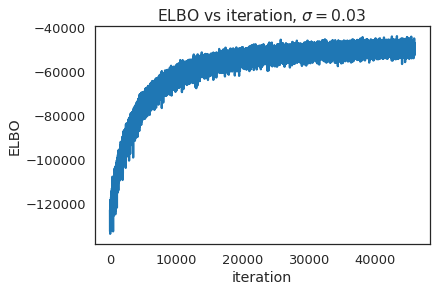

In [7]:
plt.plot(-inference.hist[4000:])
plt.ylabel('ELBO')
plt.xlabel('iteration')
plt.title("ELBO vs iteration, $\sigma = 0.03$")
plt.show()

We zoom-in on the plot below, showing only iterations 2000 through 50000.

We now compute the accuracy of our predictions on the test set. We do this by estimating 500 sets of posterior predictives, and then for each digit in the test set, we take the mode of the 500 posterior predictives as its predicted digit. We then determine the percentage of digits that the model classifies correctly.

In [8]:
with neural_network:
    trace1 = approx.sample(draws=5000)

In [10]:
with neural_network:
    ppc1 = pm.sample_ppc(trace1, samples=1000)

100%|██████████| 1000/1000 [24:05<00:00,  1.45s/it]


In [11]:
# Replace shared variables with testing set
ann_input.set_value(test_x)
ann_output.set_value(test_y)

with neural_network:
    ppc2= pm.sample_ppc(trace1, samples=500)

100%|██████████| 500/500 [04:44<00:00,  1.76it/s]


In [13]:
print("Accuracy on test set:", accuracy_score(mode(ppc2['out'], axis=0).mode[0, :], test_y))

Accuracy on test set: 0.8981


With $\sigma = 0.03$, we obtain an accuracy of 89.81 on the test set. We now rerun our model, but with $\sigma = 0.1$.

In [4]:
# Code below adapted from http://twiecki.github.io/blog/2016/07/05/bayesian-deep-learning/
total_size = len(train_y)

ann_input = theano.shared(train_x)
ann_output = theano.shared(train_y)

n_hidden = 25 # Number of neurons in each hidden unit

# initialize
init_1 = np.random.randn(train_x.shape[1], n_hidden).astype(floatX)
init_2 = np.random.randn(n_hidden, n_hidden).astype(floatX)
init_out = np.random.randn(len(np.unique(train_y))).astype(floatX)
    
with pm.Model() as neural_network2:
    
    # Weights from input to hidden layer
    weights_in_1 = pm.Normal('w_in_1', 0, sd = 0.1, 
                             shape=(train_x.shape[1], n_hidden), testval=init_1)
    
    # Weights from 1st to 2nd layer
    weights_1_2 = pm.Normal('w_1_2', 0, sd = 0.1, 
                            shape=(n_hidden, n_hidden), testval=init_2)

    # Weights from hidden layer to output
    weights_2_out = pm.Normal('w_2_out', 0, sd= 0.1, 
                              shape=(n_hidden, len(np.unique(train_y))), testval=init_out)
    
    # Bias terms for hidden layer 1
    bias_1 = pm.Normal('b1', 0, sd = 0.1)
    
    # Bias terms for hidden layer 2
    bias_2 = pm.Normal('b2', 0, sd = 0.1)
    
    # Bias term for output layer
    bias_3 = pm.Normal('b3', 0, sd = 0.1)
    
    # Build neural-network using tanh activation function
    act_1 = T.tanh(T.dot(ann_input, 
                         weights_in_1) + bias_1)
    act_2 = T.tanh(T.dot(act_1, 
                         weights_1_2) + bias_2)
    
    act_out = T.nnet.softmax(T.dot(act_2, weights_2_out) + bias_3)
    
    out = pm.Categorical('out', 
                         act_out,
                         observed=ann_output, total_size=total_size)

In [5]:
advi_params = {
    ann_input: pm.Minibatch(train_x, batch_size=500, dtype='float32'), 
    ann_output: pm.Minibatch(train_y, batch_size=500)
}

with neural_network2:
    inference=pm.ADVI()
    approx = pm.fit(n=50000, 
                    method=inference,
                    more_replacements=advi_params, 
                    obj_optimizer=pm.adagrad(learning_rate=.1))

Average Loss = 20,691: 100%|██████████| 50000/50000 [08:39<00:00, 96.19it/s]
Finished [100%]: Average Loss = 20,680


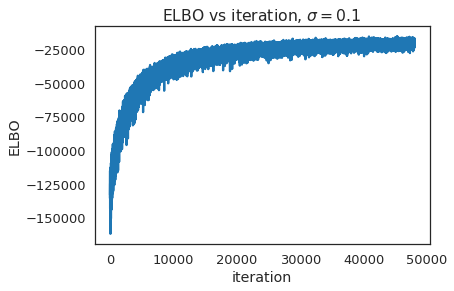

In [6]:
plt.plot(-inference.hist[2000:])
plt.ylabel('ELBO')
plt.xlabel('iteration')
plt.title("ELBO vs iteration, $\sigma = 0.1$")
plt.show()

We zoom-in on the plot below, showing only iterations 2000 through 50000.

We now compute the accuracy of our predictions on the test set using the same procedure as before.

In [7]:
with neural_network2:
    trace2 = approx.sample(draws=5000)

In [9]:
# Replace shared variables with testing set
ann_input.set_value(test_x)
ann_output.set_value(test_y)

# Creater posterior predictive samples
with neural_network2:
    ppc_21 = pm.sample_ppc(trace2, samples=500)

100%|██████████| 500/500 [07:42<00:00,  1.08it/s]


In [10]:
print("Accuracy on test set:", accuracy_score(mode(ppc_21['out'], axis=0).mode[0, :], test_y))

Accuracy on test set: 0.95735


With $\sigma = 0.1$, we obtain an accuracy of 95.74 on the test set. This is substantially better than the accuracy obtained when $\sigma = 0.03$, which was 89.81.